In [ ]:
install.packages(c("tidyverse", "skimr", "janitor", "psych", "GGally", "car", "broom", "lmtest", "sandwich", 'gridExtra'))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘cowplot’, ‘Deriv’, ‘forecast’, ‘microbenchmark’, ‘rbibutils’, ‘patchwork’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘Rdpack’, ‘RcppEigen’, ‘snakecase’, ‘mnormt’, ‘GPArotation’, ‘ggstats’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘zoo’




# Video 01.- Introduccion y marco teorico

## 1a.- Ejemplo de Sesgo de Confusion


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`geom_smooth()` using formula = 'y ~ x'


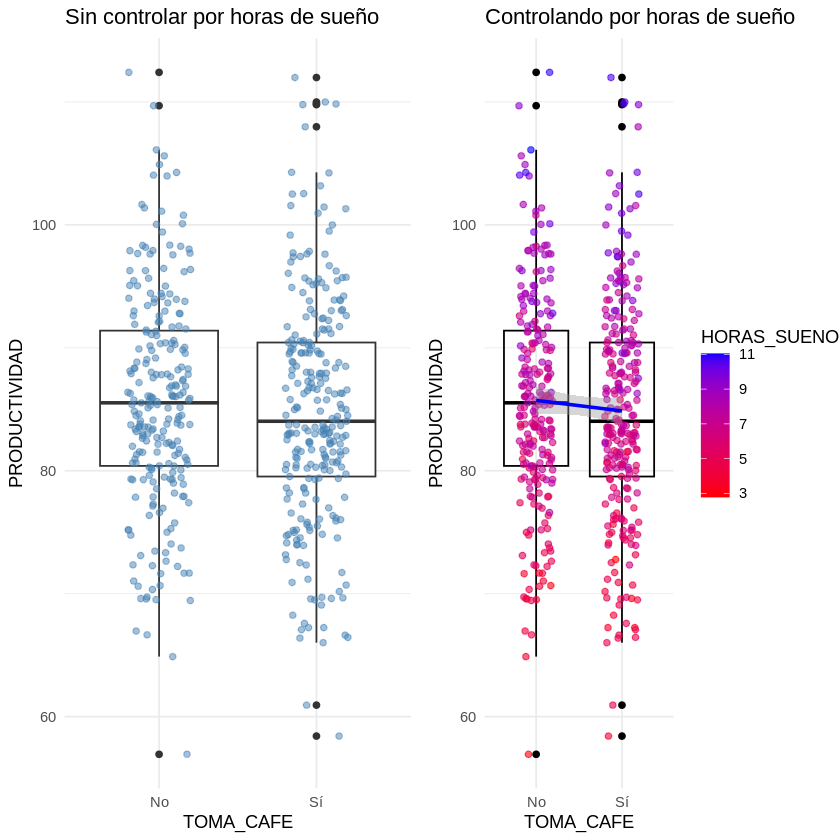

In [ ]:
#EJEMPLO SESGO DE CONFUSION
library(ggplot2)
library(dplyr)
library(gridExtra)

set.seed(123)
n <- 500
df_cafe <- data.frame(
  TOMA_CAFE = sample(c("Sí", "No"), n, replace = TRUE),
  HORAS_SUENO = rnorm(n, mean = 7, sd = 1.5)
)

df_cafe <- df_cafe %>%
  mutate(
    PRODUCTIVIDAD = 50 + 5 * HORAS_SUENO + rnorm(n, 0, 5)
  )

color_cafe <- "steelblue"  # color consistente

# Gráfico sin controlar por horas de sueño
p_sin <- ggplot(df_cafe, aes(x = TOMA_CAFE, y = PRODUCTIVIDAD)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5, color = color_cafe) +
  ggtitle("Sin controlar por horas de sueño") +
  theme_minimal()

# Gráfico controlando por horas de sueño (color según HORAS_SUENO)
p_control <- ggplot(df_cafe, aes(x = TOMA_CAFE, y = PRODUCTIVIDAD, color = HORAS_SUENO)) +
  geom_boxplot(fill = NA, color = "black") +
  geom_jitter(width = 0.2, alpha = 0.6) +
  geom_smooth(aes(group = 1), method = "lm", se = TRUE, color = "blue") +
  scale_color_gradient(low = "red", high = "blue") +
  ggtitle("Controlando por horas de sueño") +
  theme_minimal()

# Mostrar los dos gráficos juntos
grid.arrange(
  p_sin, p_control,
  ncol = 2,
  widths = c(7, 7),   # ancho relativo de cada columna
  heights = c(4)      # alto relativo (igual para ambos)
)

In [ ]:
#Sin bloquear
t.test(PRODUCTIVIDAD ~ TOMA_CAFE, data = df_cafe)



	Welch Two Sample t-test

data:  PRODUCTIVIDAD by TOMA_CAFE
t = 1.0698, df = 497.33, p-value = 0.2852
alternative hypothesis: true difference in means between group No and group Sí is not equal to 0
95 percent confidence interval:
 -0.7231671  2.4519654
sample estimates:
mean in group No mean in group Sí 
        85.72686         84.86246 


In [ ]:
#Bloqueando
modelo <- lm(PRODUCTIVIDAD ~ TOMA_CAFE + HORAS_SUENO, data = df_cafe)
summary(modelo)



Call:
lm(formula = PRODUCTIVIDAD ~ TOMA_CAFE + HORAS_SUENO, data = df_cafe)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.9806  -3.4691  -0.0901   3.0349  15.8086 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 50.29771    1.12868  44.563   <2e-16 ***
TOMA_CAFESí  0.09364    0.45649   0.205    0.838    
HORAS_SUENO  4.96675    0.15135  32.816   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.088 on 497 degrees of freedom
Multiple R-squared:  0.6849,	Adjusted R-squared:  0.6837 
F-statistic: 540.2 on 2 and 497 DF,  p-value: < 2.2e-16


## 1b.- Ejemplo de Sesgo de seleccion


	Welch Two Sample t-test

data:  Estres by ActividadFisica
t = 6.4735, df = 487.42, p-value = 2.339e-10
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 2.079531 3.892017
sample estimates:
mean in group 0 mean in group 1 
       50.08764        47.10187 



	Welch Two Sample t-test

data:  Estres by ActividadFisica
t = 1.7033, df = 148.47, p-value = 0.09061
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.2073157  2.7963603
sample estimates:
mean in group 0 mean in group 1 
       50.49407        49.19955 


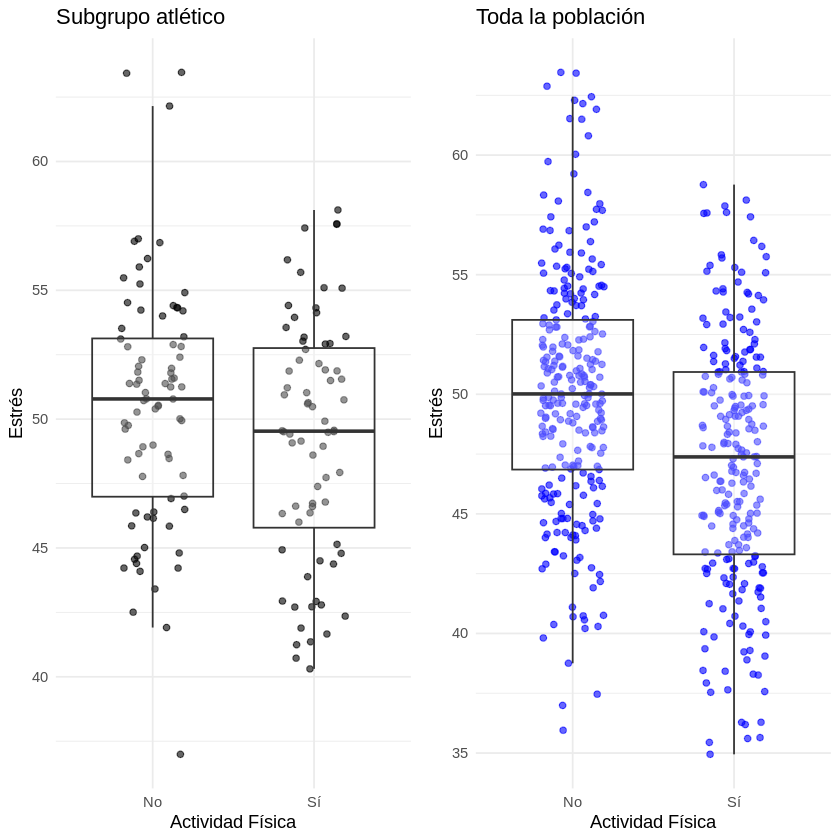

In [ ]:
set.seed(123)

# ---- Crear datos ----
n_total <- 500
df <- data.frame(
  ActividadFisica = rbinom(n_total, 1, 0.5),   # 0 = No, 1 = Sí
  Atletico = rbinom(n_total, 1, 0.3)           # 0 = no atlético, 1 = atlético
)

# ---- Estrés para toda la población (efecto nulo) ----
df$Estres <- rnorm(n_total, mean = 50, sd = 5)

# ---- Introducir efecto artificial en el subgrupo atlético ----
df$Estres[df$Atletico == 0 & df$ActividadFisica == 1] <-
  df$Estres[df$Atletico == 0 & df$ActividadFisica == 1] - 4  # bajar estrés en activos atléticos

# ---- Subgrupo atlético ----
df_atletico <- df[df$Atletico == 1, ]

# ---- Graficar lado a lado ----
library(ggplot2)

p_total <- ggplot(df, aes(x = factor(ActividadFisica, labels = c("No", "Sí")), y = Estres)) +
  geom_jitter(width = 0.2, height = 0, color = "blue", alpha = 0.6) +
  geom_boxplot(alpha = 0.3, outlier.shape = NA) +
  labs(title = "Toda la población", x = "Actividad Física", y = "Estrés") +
  theme_minimal()

p_atletico <- ggplot(df_atletico, aes(x = factor(ActividadFisica, labels = c("No", "Sí")), y = Estres)) +
  geom_jitter(width = 0.2, height = 0, color = "black", alpha = 0.6) +
  geom_boxplot(alpha = 0.3, outlier.shape = NA) +
  labs(title = "Subgrupo atlético", x = "Actividad Física", y = "Estrés") +
  theme_minimal()

# ---- Combinar gráficos ----
library(gridExtra)
grid.arrange(p_atletico, p_total, ncol = 2)

# ---- Test estadístico ----
# Población total
t_total <- t.test(Estres ~ ActividadFisica, data = df)
# Subgrupo atlético
t_atletico <- t.test(Estres ~ ActividadFisica, data = df_atletico)

t_total
t_atletico




# Video 02.- EDA

In [ ]:
df <- read.csv(file = "https://infra.datos.gob.ar/catalog/sedronar/dataset/5/distribution/5.1/download/base-hogares-2022.csv", sep = ';')
head(df)

,ID_PER,WPER,CANT_MIEMBROS_HOGAR,CANT_PERSONAS0A17,CLIMA_EDUCATIVO,J_SEXO,J_EDAD,J_NIVEL_EDUCATIVO,SEXO_SEL,EDAD_SEL,⋯,ID_06B,ID_06C,ID_06D,ID_06E,ID_06F,ID_06G,ID_06H,ID_06I,ID_07,ID_08
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,336578,124,1,0,2,1,27,4,1,27,⋯,4,2,2,1,1,99,2,3,1,98
2,305909,781,1,0,3,1,33,6,1,33,⋯,2,2,1,3,2,3,2,4,2,NA
3,358892,34193,4,1,2,1,43,4,2,19,⋯,1,2,2,4,2,4,2,2,2,NA
4,342664,968,1,0,3,2,51,6,2,51,⋯,1,4,4,1,1,1,1,1,2,NA
5,394688,11509,2,0,3,2,59,5,1,31,⋯,2,1,1,2,2,4,2,2,2,NA
6,370155,13159,2,0,3,2,44,5,2,44,⋯,1,99,1,1,1,2,1,1,1,98


In [ ]:
library(tidyverse)
library(janitor)
library(psych)
library(GGally)
library(car)
library(broom)
library(lmtest)
library(sandwich)
library(dplyr)

ERROR: Error in library(janitor): there is no package called ‘janitor’


In [ ]:
paste("Cantidad de filas:", nrow(df))
paste("Cantidad de columnas:", length(df))

[1] "Cantidad de filas: 12062"

[1] "Cantidad de columnas: 562"

## 2a.- Categorias presentes de la variable de interes

In [ ]:
df %>% count(NIVEL_EDUCATIVO_SEL)

NIVEL_EDUCATIVO_SEL,n
<int>,<int>
1,518
2,1568
3,2235
4,3162
5,2050
6,2466
7,63


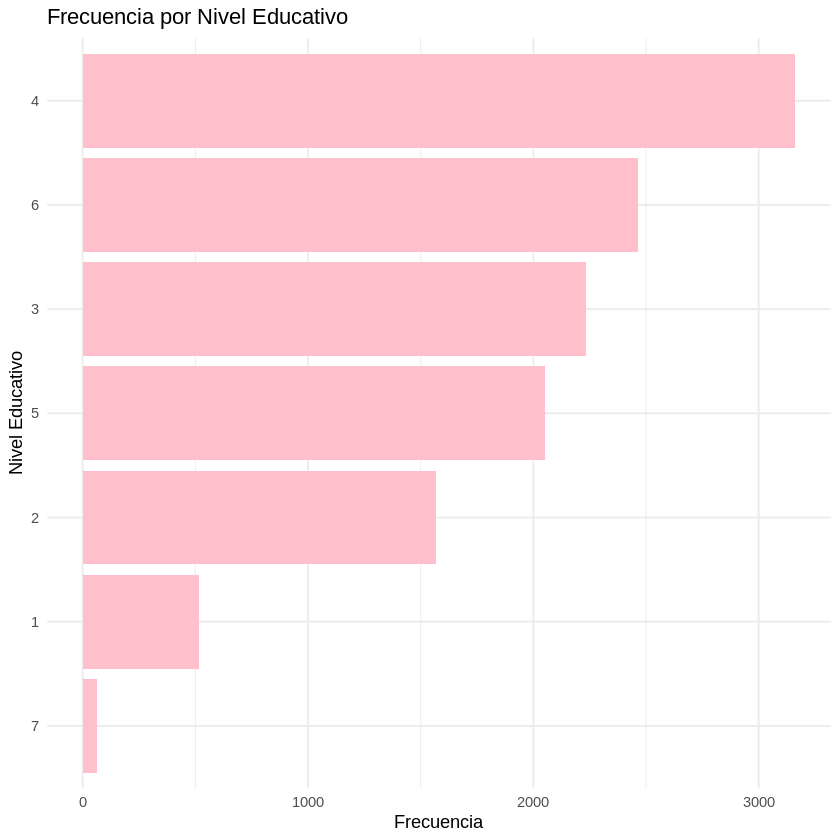

In [ ]:
df %>%
  count(NIVEL_EDUCATIVO_SEL) %>%
  ggplot(aes(x = reorder(NIVEL_EDUCATIVO_SEL, n), y = n)) +
  geom_col(fill = "pink") +
  labs(title = "Frecuencia por Nivel Educativo",
       x = "Nivel Educativo",
       y = "Frecuencia") +
  coord_flip() +
  theme_minimal()


 Reordeno factores eliminando y usando los incompletos dado que inclueyen los niveles anteriores.

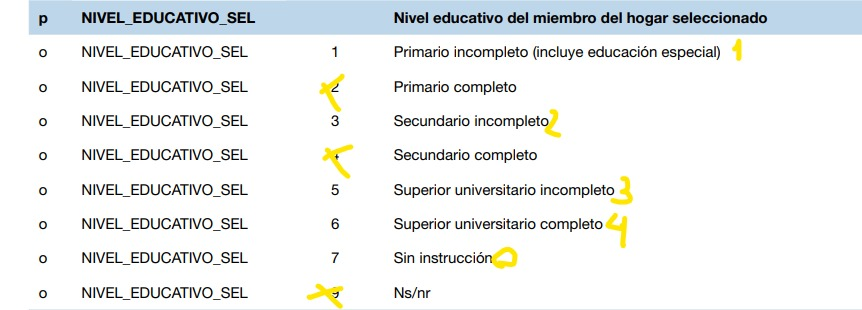

## 2b.- Distribucion de variables antes de generar los indices

Warning message:
“Removed 18939 rows containing non-finite outside the scale range
(`stat_bin()`).”


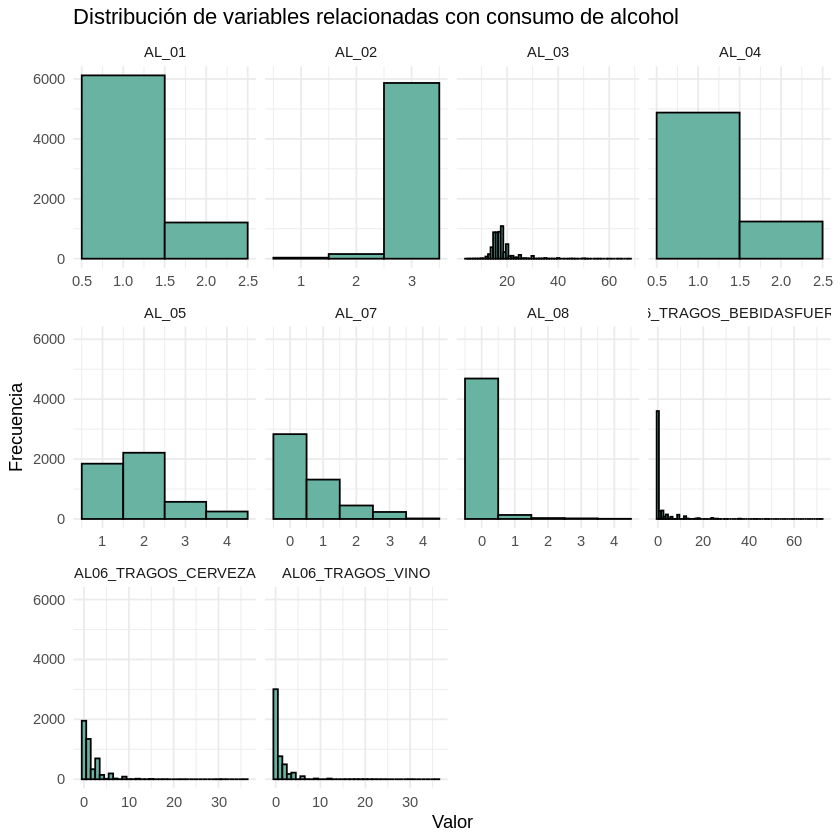

In [ ]:
#Distribucion de variables relacionadas al alcohol antes de crear el indice.

library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)

# ---- FUNCIONES DE LIMPIEZA ----
# Convertir comas a punto y numeric
clean_numeric <- function(x) {
  if (is.character(x)) {
    x <- str_replace_all(x, ",", ".")
  }
  as.numeric(x)
}

# Reemplazar valores de "No contesta / No sabe / No recuerda" por NA
recode_missing <- function(x) {
  na_if(na_if(na_if(na_if(x, 98), 99), 998), 999)
}

# ---- VARIABLES RELACIONADAS CON ALCOHOL ----
alcohol_vars <- c(
  "AL_01", "AL_02", "AL_03", "AL_04", "AL_05",
  "AL_07", "AL_08",
  "AL06_TRAGOS_CERVEZA", "AL06_TRAGOS_VINO", "AL06_TRAGOS_BEBIDASFUERTES"
)

# ---- LIMPIEZA Y TRANSFORMACIÓN ----
df_alcohol <- df %>%
  select(all_of(alcohol_vars)) %>%
  mutate(across(everything(), clean_numeric)) %>%
  mutate(across(everything(), recode_missing))

# ---- PREPARAR PARA GRAFICOS ----
# Convertir de wide a long
df_long <- df_alcohol %>%
  pivot_longer(cols = everything(), names_to = "variable", values_to = "valor")

# ---- GRAFICO CON FACETAS ----
p_alcohol <- ggplot(df_long, aes(x = valor)) +
  geom_histogram(binwidth = 1, fill = "#69b3a2", color = "black") +
  facet_wrap(~variable, scales = "free_x") +
  labs(
    title = "Distribución de variables relacionadas con consumo de alcohol",
    x = "Valor",
    y = "Frecuencia"
  ) +
  theme_minimal()

# ---- MOSTRAR GRAFICO ----
p_alcohol




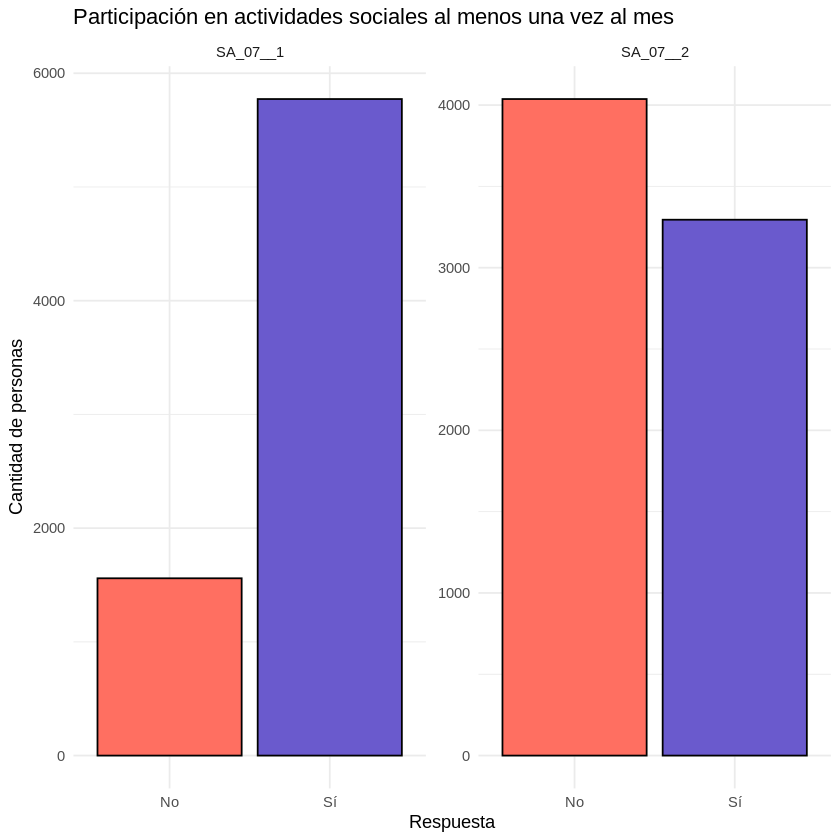

In [ ]:
# Idem para eventos sociales


library(dplyr)
library(tidyr)
library(ggplot2)

# ---- VARIABLES DE EVENTOS SOCIALES ----
social_vars <- c("SA_07__1", "SA_07__2")

# ---- LIMPIEZA Y TRANSFORMACIÓN ----
df_social <- df %>%
  select(all_of(social_vars)) %>%
  mutate(across(everything(), ~na_if(.x, 99)))  # suponer 99 = No contesta

# ---- PREPARAR PARA GRAFICOS ----
# Convertir de wide a long
df_long_social <- df_social %>%
  pivot_longer(cols = everything(), names_to = "variable", values_to = "valor") %>%
  mutate(valor = factor(valor, levels = c(0,1), labels = c("No", "Sí")))

# ---- GRAFICO CON FACETAS ----
p_social <- ggplot(df_long_social, aes(x = valor, fill = valor)) +
  geom_bar(color = "black") +
  facet_wrap(~variable, scales = "free_y") +
  labs(
    title = "Participación en actividades sociales al menos una vez al mes",
    x = "Respuesta",
    y = "Cantidad de personas"
  ) +
  theme_minimal() +
  scale_fill_manual(values = c("No" = "#FF6F61", "Sí" = "#6A5ACD")) +
  theme(legend.position = "none")

# ---- MOSTRAR GRAFICO ----
p_social



## 2c.- Genero indices: alcohol y eventos sociales.

In [ ]:
# ---- VARIABLES ----
social_vars <- c("SA_07__1", "SA_07__2")
alcohol_vars <- c(
  "AL_01", "AL_02", "AL_03", "AL_04", "AL_05",
  "AL_07", "AL_08",
  "AL06_TRAGOS_CERVEZA", "AL06_TRAGOS_VINO", "AL06_TRAGOS_BEBIDASFUERTES"
)

# ---- Filtrar solo columnas existentes en df ----
social_vars <- social_vars[social_vars %in% names(df)]
alcohol_vars <- alcohol_vars[alcohol_vars %in% names(df)]

# ---- Reemplazar códigos de no respuesta por NA y convertir a numérico ----
df[social_vars] <- lapply(df[social_vars], function(x) {
  x <- as.numeric(as.character(x))
  x[x %in% c(99,998,999)] <- NA
  return(x)
})

df[alcohol_vars] <- lapply(df[alcohol_vars], function(x) {
  x <- as.numeric(as.character(x))
  x[x %in% c(99,998,999)] <- NA
  return(x)
})

# ---- Crear índices ----
df$INDICE_SOCIALES <- rowSums(df[social_vars], na.rm = TRUE)
df$INDICE_ALCOHOL <- rowSums(df[alcohol_vars], na.rm = TRUE)

# ---- Revisar las primeras filas ----
head(df[, c("INDICE_SOCIALES", "INDICE_ALCOHOL")])




Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”


,INDICE_SOCIALES,INDICE_ALCOHOL
,<dbl>,<dbl>
1,0,23
2,1,38
3,2,25
4,2,21
5,2,31
6,2,15


## 2d.- Scatterplot con y sin bloquear por "eventos sociales"


Call:
lm(formula = INDICE_CONSUMO_ALCOHOL ~ NIVEL_EDUCATIVO_SEL, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.665  -1.665   1.558   4.558 115.781 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          21.7733     0.4937  44.103   <2e-16 ***
NIVEL_EDUCATIVO_SEL   0.2230     0.1629   1.369    0.171    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.83 on 7330 degrees of freedom
Multiple R-squared:  0.0002556,	Adjusted R-squared:  0.0001192 
F-statistic: 1.874 on 1 and 7330 DF,  p-value: 0.1711


`geom_smooth()` using formula = 'y ~ x'


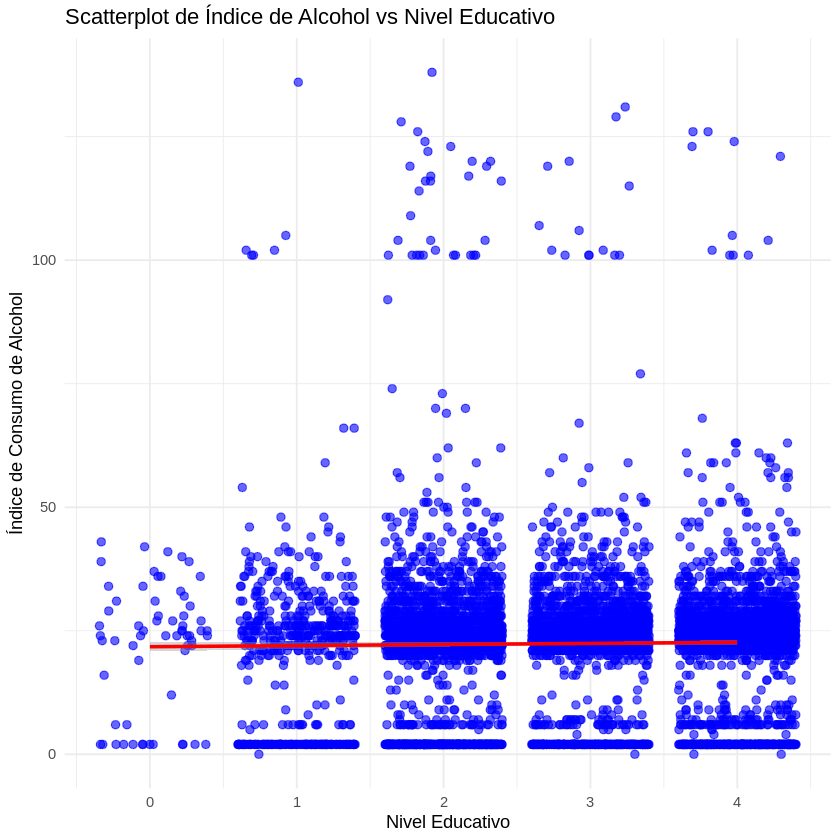

In [ ]:

# ---- Asegurarse que las variables existen ----
if(!"INDICE_CONSUMO_ALCOHOL" %in% names(df)) {
  df$INDICE_CONSUMO_ALCOHOL <- df$INDICE_ALCOHOL
}


# ---- Ajustar modelo lineal ----
modelo_simple <- lm(INDICE_CONSUMO_ALCOHOL ~ NIVEL_EDUCATIVO_SEL, data = df)

# ---- Revisar resumen del modelo ----
summary(modelo_simple)

library(ggplot2)
ggplot(df, aes(x = as.numeric(NIVEL_EDUCATIVO_SEL), y = INDICE_CONSUMO_ALCOHOL)) +
  geom_jitter(height = 0, color = "blue", size = 2, alpha = 0.6) +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "solid") +
  labs(
    x = "Nivel Educativo",
    y = "Índice de Consumo de Alcohol",
    title = "Scatterplot de Índice de Alcohol vs Nivel Educativo"
  ) +
  theme_minimal()






Alto Bajo 
3065 4267 


Call:
lm(formula = INDICE_CONSUMO_ALCOHOL ~ as.numeric(NIVEL_EDUCATIVO_SEL) + 
    SOCIAL_BIN, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.538  -2.462   1.462   4.462 116.399 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     23.38622    0.57119  40.943  < 2e-16 ***
as.numeric(NIVEL_EDUCATIVO_SEL)  0.03794    0.16589   0.229    0.819    
SOCIAL_BINBajo                  -1.86067    0.33341  -5.581 2.48e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.8 on 7329 degrees of freedom
Multiple R-squared:  0.004486,	Adjusted R-squared:  0.004214 
F-statistic: 16.51 on 2 and 7329 DF,  p-value: 6.99e-08


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


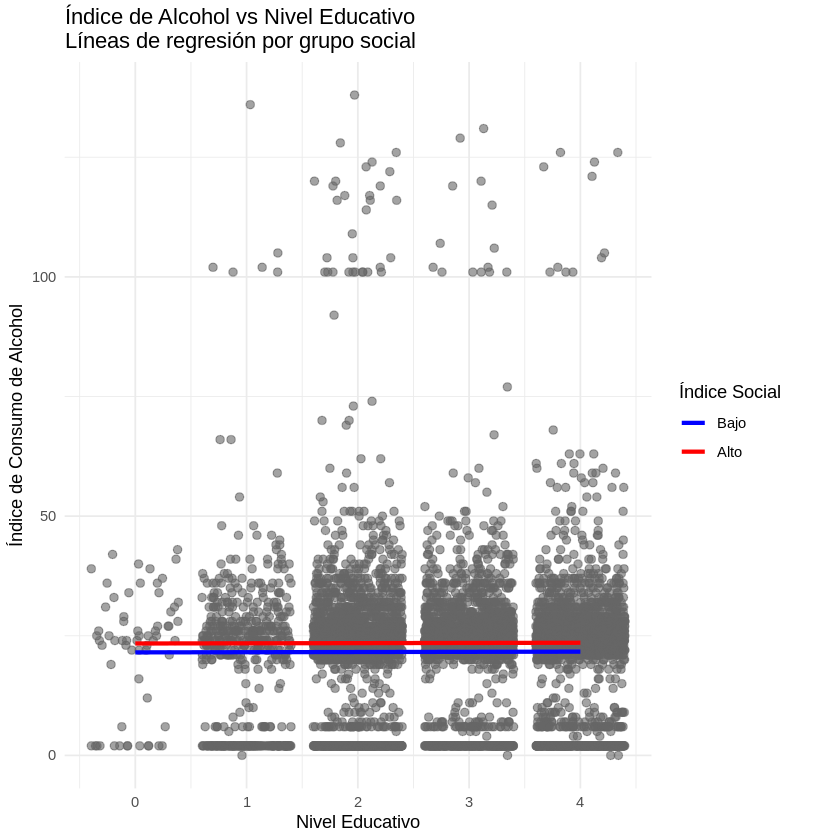

In [ ]:
library(ggplot2)

# ---- Binarizar INDICE_SOCIALES ----
mediana_social <- median(df$INDICE_SOCIALES, na.rm = TRUE)
df$SOCIAL_BIN <- ifelse(df$INDICE_SOCIALES > mediana_social, "Alto", "Bajo")

# Revisar tabla
table(df$SOCIAL_BIN, useNA = "ifany")

# ---- Ajustar modelo lineal múltiple con binario ----
modelo_control_bin <- lm(INDICE_CONSUMO_ALCOHOL ~ as.numeric(NIVEL_EDUCATIVO_SEL) + SOCIAL_BIN, data = df)

# ---- Revisar resumen del modelo ----
summary(modelo_control_bin)

# ---- Crear predicciones para cada grupo ----
niveles_educativos <- sort(unique(df$NIVEL_EDUCATIVO_SEL))
pred_data <- expand.grid(
  NIVEL_EDUCATIVO_SEL = niveles_educativos,
  SOCIAL_BIN = c("Bajo", "Alto")
)
pred_data$fit <- predict(modelo_control_bin, newdata = pred_data)

# ---- Graficar scatterplot con líneas separadas por grupo ----
ggplot(df, aes(x = as.numeric(NIVEL_EDUCATIVO_SEL), y = INDICE_CONSUMO_ALCOHOL)) +
  geom_jitter(height = 0, color = "gray40", size = 2, alpha = 0.6) +
  geom_line(data = pred_data, aes(x = as.numeric(NIVEL_EDUCATIVO_SEL), y = fit, color = SOCIAL_BIN), size = 1.2) +
  scale_color_manual(values = c("Bajo" = "blue", "Alto" = "red")) +
  labs(
    x = "Nivel Educativo",
    y = "Índice de Consumo de Alcohol",
    color = "Índice Social",
    title = "Índice de Alcohol vs Nivel Educativo\nLíneas de regresión por grupo social"
  ) +
  theme_minimal()


#Tratamiento de nulos (No sabe no contesta)

In [ ]:
valores_nulos_globales <- c(98, 99, 777, 888, 998, 999)

df_limpio <- df %>%
  mutate(across(where(is.numeric),
                ~ if_else(.x %in% valores_nulos_globales, NA_real_, .x)))

# ---------------------------------------------------------
# ETAPA 2: Limpieza Específica (El código 9)
# ---------------------------------------------------------
# Solo para variables donde el manual indica explícitamente "9 = Ns/nr"
cols_con_9_nulo <- c("J_NIVEL_EDUCATIVO",
                     "NIVEL_EDUCATIVO_SEL",
                     "COBERTURA_SEL")

df_limpio <- df_limpio %>%
  mutate(across(all_of(cols_con_9_nulo),
                ~ if_else(.x == 9, NA_real_, .x)))

In [ ]:
head(df_limpio)

,ID_PER,WPER,CANT_MIEMBROS_HOGAR,CANT_PERSONAS0A17,CLIMA_EDUCATIVO,J_SEXO,J_EDAD,J_NIVEL_EDUCATIVO,SEXO_SEL,EDAD_SEL,⋯,ID_06F,ID_06G,ID_06H,ID_06I,ID_07,ID_08,INDICE_SOCIALES,INDICE_ALCOHOL,INDICE_CONSUMO_ALCOHOL,SOCIAL_BIN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,305909,781,1,0,3,1,33,6,Varon,33,⋯,2,3,2,4,2,NA,0,23,23,Bajo
2,342664,968,1,0,3,2,51,6,Mujer,51,⋯,1,1,1,1,2,NA,1,38,38,Bajo
3,394688,11509,2,0,3,2,59,5,Varon,31,⋯,2,4,2,2,2,NA,2,25,25,Alto
4,370155,13159,2,0,3,2,44,5,Mujer,44,⋯,1,2,1,1,1,NA,2,21,21,Alto
5,390628,315,3,0,2,2,56,3,Varon,24,⋯,3,3,2,3,1,NA,2,31,31,Alto
6,370771,2545,5,2,2,1,60,5,Varon,24,⋯,NA,NA,2,3,1,1,2,15,15,Alto
